<a href="https://colab.research.google.com/github/LSSTDESC/jax-perlmutter-tutorials/blob/main/notebooks/DESCJaxTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESC JAX Tutorial

Author:
- [@EiffL](https://github.com/EiffL)(Francois Lanusse)

## Overview

The goal of this tutorial is to cover some of the essential JAX mechanisms, and
put them into practice for typical computations that may be required for a project like CCL

**Learning objectives**:
- Learn about JAX function transformations
- Learn about common gotchas when using JAX
- Implement integrations and ODE in JAX



## JAX 101

We will start by a brief overview of JAX fundamentals, this is an abrieged version of what you can find in the official JAX documentation:
- [JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)
- [JAX 101](https://jax.readthedocs.io/en/latest/jax-101/index.html)




In [ ]:
%pylab inline
import jax
import jax.numpy as np
import numpy as onp    # We'll import good old numpy as onp for reference if we need it

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Random Numbers (let's get it out of the way)

JAX has a much more evolved approach to random number generation than NumPy, design to allow parallel random number generators. It is also needed to statisfy the JAX pure function approach.

To use any stochastic function in JAX, you need to specify a key, which is a seed that the function can then use internally. So let's create one:

In [ ]:
rng_key = jax.random.PRNGKey(42) # Because 42 is the answer

Then everytime I need a key for a stochastic operation I can use:

In [ ]:
key, rng_key = jax.random.split(rng_key)
random_array = jax.random.normal(key, shape=[10])

In [ ]:
key2, rng_key = jax.random.split(rng_key)
random_array2 = jax.random.normal(key2, shape=[10])

In [ ]:
random_array2, random_array

(DeviceArray([-0.55206573,  0.44049525, -0.22900735,  0.35642126,
              -0.9225792 , -1.743125  , -1.1097171 , -1.9355716 ,
              -2.0792866 , -0.9502306 ], dtype=float32),
 DeviceArray([ 0.84930754,  1.9506735 , -0.04741636, -0.81005794,
              -0.8750629 , -0.8775995 , -0.83418566, -1.6659447 ,
               1.4172531 , -0.9020335 ], dtype=float32))

this key is only used for this operation, and next time I need to run an stochastic operation I can split again `rng_key` to obtain a new key.

#### JAX works just like NumPy (most of the time)

Let's start with very simple stuff, a matrix multiplication:

In [ ]:
key1, key2, rng_key = jax.random.split(rng_key, 3)

# I'm gonna create some random matrices
A = jax.random.normal(key1, [500,1000])
B = jax.random.normal(key2, [1000, 500])

In [ ]:
C = np.dot(A, B) 
print("Shape of result:", C.shape)

Shape of result: (500, 500)


Under the hood, if you have a GPU, this matrix multiplication happened on GPU ;-) 

In [ ]:
C.argmax() # Random numpy operation

DeviceArray(63784, dtype=int32)


But you also have access to a lot of other linear algebra tools:

- [jax.scipy.linalg](https://jax.readthedocs.io/en/latest/jax.scipy.html#module-jax.scipy.linalg)
- [jax.scipy.optimize](https://jax.readthedocs.io/en/latest/jax.scipy.html#module-jax.scipy.optimize)
- [jax.scipy.special](https://jax.readthedocs.io/en/latest/jax.scipy.html#module-jax.scipy.special)

In [ ]:
from jax.scipy.linalg import svd
U, s, V = svd(C)  # Example of an SVD

In [ ]:
from scipy.linalg import svd
U, s, V = svd(C)

In [ ]:
U

array([[ 0.01336075, -0.01101637, -0.00279735, ...,  0.05248459,
         0.11655822, -0.02028303],
       [ 0.04535291, -0.0395796 ,  0.04957964, ...,  0.03929463,
        -0.01981924,  0.03008807],
       [ 0.11921653,  0.00844285, -0.053387  , ..., -0.02711241,
         0.02167287, -0.01226401],
       ...,
       [-0.01325856,  0.00375808, -0.06297591, ..., -0.05795874,
        -0.0386828 , -0.02884904],
       [-0.00371668,  0.04458942, -0.01970376, ...,  0.04075874,
        -0.02886263, -0.0596433 ],
       [ 0.03717032, -0.0554039 ,  0.02463041, ..., -0.04617457,
        -0.09748892,  0.01552525]], dtype=float32)

#### Just in Time Compilation


When you execute JAX code without JIT, you run through the code at the Python level, until you encounter the low level XLA interface, which is hidden behind the numpy API. At that point, the XLA bit of code is executed, and the result is returned to Python which continues to run through the next commands.

This can be pretty slow because the execution is still driven by Python.

So the idea of JAX is that you can jit a big function, to turn it into a single,compiled XLA graph, that runs without needing Python

In [ ]:
def func(A, B):
  C = np.dot(A, B)
  C = np.where(C>0, C, 0)
  return C

In [ ]:
%timeit func(A, B).block_until_ready()

The slowest run took 137.46 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 1.02 ms per loop


In [ ]:
jitted_func = jax.jit(func)
%time jitted_func(A, B).block_until_ready(); # First execution won't be fast

CPU times: user 18.5 ms, sys: 628 µs, total: 19.1 ms
Wall time: 72.6 ms


DeviceArray([[ 8.078229 ,  0.       , 52.79737  , ...,  0.       ,
               4.5134783, 34.29931  ],
             [ 0.       , 49.137123 ,  0.       , ..., 17.208092 ,
               0.       , 20.391201 ],
             [ 0.       , 42.54201  , 12.696964 , ..., 17.1001   ,
              34.664677 , 22.168022 ],
             ...,
             [ 0.       ,  0.       , 13.421769 , ...,  0.       ,
              16.509678 , 17.185503 ],
             [38.584465 ,  0.6224303,  0.       , ...,  0.5508528,
              21.78602  ,  0.       ],
             [41.79374  ,  0.       ,  8.752552 , ...,  0.       ,
               6.700938 , 49.400196 ]], dtype=float32)

In [ ]:
%timeit jitted_func(A,B).block_until_ready() #  Next calls are fast

The slowest run took 8.99 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 138 µs per loop


For fun, we can compare to CPU using good old numpy:

In [ ]:
A_np = onp.array(A)
B_np = onp.array(B)

def func_onp(A, B):
  C = onp.dot(A, B)
  C = onp.where(C>0, C, 0)
  return C

In [ ]:
%timeit func_onp(A_np, B_np)

100 loops, best of 5: 6.13 ms per loop


#### Auto-batching with vmap


Any function can be "batched" which means that you add a new dimension to the input/output tensors.

So, let's say I want to make my previous function compute that operation for 10 matrices at once.

If I try to use the function directly, it won't work, because  that function was written thinking about single input matrices:

In [ ]:
A2 = jax.random.normal(key1, shape=[10, 500,1000])
B2 = jax.random.normal(key2, shape=[10, 1000, 500])

In [ ]:
func(A2, B2).shape

(10, 500, 10, 500)

But we would have expected an output of shape [10, 500, 500].

So, let's use vmap:

In [ ]:
batched_func = jax.vmap(func)

In [ ]:
batched_func(A2,B2).shape

(10, 500, 500)

Boom :-) We just turned a function designed to work on a single example of matrices into a batched function.

And you can also compose jit and vmap

In [ ]:
cool_func = jax.jit(jax.vmap(func))

In [ ]:
cool_func(A2,B2)
%timeit cool_func(A2,B2).block_until_ready()

1000 loops, best of 5: 780 µs per loop


Note that this takes less than 10 times the execution time of a single instance.

#### Getting gradients with grad, jacfwd

Obviously, one of the things we care about the most here are gradients, so let's give it a try.

In [ ]:
# I'm gonna create an array of some parameters
params = jax.random.normal(key1, shape=[500])

def f(params, A, B):
  C = np.dot(A, B)
  C = np.where(C>0, C, 0)
  return np.sum(C.dot(params)**2)

In [ ]:
f(params, A, B) # Ok so this function does something, ok:

DeviceArray(1.816143e+08, dtype=float32)

Let me take the derivative of this function. jax.grad will compute the derivative of this function with respect to the first argument of f:

In [ ]:
df_dx = jax.grad(f)

In [ ]:
df_dx

<function __main__.f>

In [ ]:
g = df_dx(params, A, B)

In [ ]:
g.shape # And we can check that the grad has the same dimensionality as the
        # input array

(500,)

But what happens if I want to take the Jacobian of a  non scalar function? Well, let's just use jax.jacobian

In [ ]:
def f2(params, A, B):
  C = np.dot(A, B)
  return C.dot(params**2)

In [ ]:
f2(params, A, B).shape

(500,)

In [ ]:
df2_dx = jax.jacobian(f2)

In [ ]:
df2_dx(params, A, B).shape

(500, 500)

Boom, we have computed:
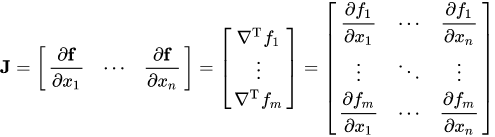


But that's not all :-) You can compose gradients! For instance:

In [ ]:
dfunc_dx = jax.grad(lambda x, A, B: np.sum(jax.jacobian(f2)(x, A, B)))

In [ ]:
dfunc_dx(params, A, B).shape

(500,)

This is for instance what we used in the tomo challenge to get gradients of the Fisher matrix ;-) 

**Something to know about autodiff**: There are two types of autodiff, **forward** and **backward** automatic differentiation. JAX supports both, and you should know the  following:
- backward autodiff is good when `f` has small dimensionality of output
- forward autodiff is good when `f` has small dimensionality of input

Depending on the relative size of inputs and outputs, you may prefer the dedicated `jax.jacfwd` and `jax.jacrev`

Check the [autodiff cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#) to know more.


## Where will JAX suprise you?

As mentioned in the previous section, to get all of this goodness, JAX needs to
make some assumptions, which may change a little bit from your habits, and therefore can suprise you at first.

#### JAX wants pure functions

JAX is based on a purely functional approach, with no side effects. A pure function is a function where the output only depends on the inputs of the function.

Let's see what we mean by that by creating a simple jitted function:

In [ ]:
@jax.jit
def my_func(x):
  print("Baguette")
  return 2*np.abs(x)

In [ ]:
y = my_func(0) # The first time I execute it I get:

Baguette


In [ ]:
y = my_func(1) #  Second time: I see no print!

In [ ]:
y = my_func(2.0) # Third time: The print is back???

Baguette


This is because print is a `side effect` and not actually something that depends on the input and affects the output, so it is not included in the compiled graph, it only shows up when JAX traces the function to recompile it.

The fact that the third time work again is because JAX detected that the function was being applied on a float now, instead of an int, so it recompiles the function for float inputs.

#### Your code encounters a tracer instead of an actual value

Another example of something suprising:

In [ ]:
@jax.jit
def myfun(x):
  if x > 1:
    y = 0
  else:
    y = x
  return y

In [ ]:
myfun(1)

This doesnt work because when JAX traces the function, it records the execution of the function using an abstract "tracer" instead of a concrete tensor. If your code encouters something that doesn't know how to handle such a tracer, it will trigger an error. 

To fix this here, you need to use the jax NumPy API:

In [ ]:
@jax.jit
def myfun(x):
  y = np.where(x > 1, 0, x)
  return y

myfun(1)

DeviceArray(1, dtype=int32)

Or  use a lower level [jax.lax](https://jax.readthedocs.io/en/latest/jax.lax.html) control flow instruction. This is more advanced...

Checkout [this part](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#structured-control-flow-primitives) of the JAX documentation maybe.


$$
\begin{array} {r|rr} 
\hline \
\textrm{construct} 
& \textrm{jit} 
& \textrm{grad} \\
\hline \
\textrm{if} & ❌ & ✔ \\
\textrm{for} & ✔* & ✔\\
\textrm{while} & ✔* & ✔\\
\textrm{lax.cond} & ✔ & ✔\\
\textrm{lax.while_loop} & ✔ & \textrm{fwd}\\
\textrm{lax.fori_loop} & ✔ & \textrm{fwd}\\
\textrm{lax.scan} & ✔ & ✔\\
\hline
\end{array}
$$
<center>$\ast$ = argument-__value__-independent loop condition - unrolls the loop </center>



#### In JAX you can't assign values to an array

In [ ]:
myarray = np.arange(10)   # Let's create and array
myarray[5] = 0            # And try to assign a value

**The reason**: Allowing in-place mutation of variables makes the tracing difficult, so JAX doesn't allow it.

**The solution**:
- Most of the time, you don't need such assignement, and can rewrite this in other ways
- If you really need to, you can use **functional** API tools like [index_update](https://jax.readthedocs.io/en/latest/_autosummary/jax.ops.index_update.html#jax.ops.index_update)

In [ ]:
myarray = np.arange(10)
print("Input     ", myarray)

# Solution 1: We might want to set a value to zero because it's masked
# in such a case, we can simply multiply the input array by a mask
mask = np.where(myarray == 5,0,1) 
myarray1 = mask * myarray
print("Solution 1", myarray1)

# Solution 2: If really you need to update, you can use jax.ops.index_update
myarray2 = jax.ops.index_update(myarray, 5, 0.)
print("Solution 2", myarray2)

Input      [0 1 2 3 4 5 6 7 8 9]
Solution 1 [0 1 2 3 4 0 6 7 8 9]
Solution 2 [0 1 2 3 4 0 6 7 8 9]


## Autodiff showdown

Here are a few cool examples of autodiff to compare against Julia.

#### You can differentiate with respect to objects!

This is not possible in TensorFlow for instance. So imagine this:

In [ ]:
def myfunc(cosmo):
  return 2* cosmo["sigma8"]**2 + 1

In [ ]:
cosmo = {"sigma8": 0.8, "omega_m":0.3}

In [ ]:
jax.grad(myfunc)(cosmo)

{'omega_m': array(0., dtype=float32),
 'sigma8': DeviceArray(3.2, dtype=float32)}

In this case this is a simple dictionary, but you can register your own objects
so that they can be recognized by JAX's autodiff. See [here](https://jax.readthedocs.io/en/latest/pytrees.html)

In jax-cosmo, you can take derivatives with respect to `objects` like redshift distributions, and cosmology :-)  

## Examples of useful implementations


### End-to-End Limber Integration Example

One of the most frequent things we need to do usually is evaluating an integral over a power spectrum.

In [ ]:
def simps(f, a, b, N=128):
  """ Simple Simspon's integration 
  Args:
    f: vectorized function providing the integrand
    a,b: float, interval of integraions
    N: integer, number of points to evaluate the integrand 
  """
  if N % 2 == 1:
      raise ValueError("N must be an even integer.")
  dx = (b - a) / N                # Step between points 
  x = np.linspace(a, b, N + 1)    # Grid for the evaluation of integrand
  y = f(x)                        # Evaluate the integrand on appropriate grid
  return dx / 3 * np.sum(y[0:-1:2] + 4 * y[1::2] + y[2::2], axis=0) # Simpson's rule

In [ ]:
pip install --quiet jax-cosmo

Let's try to use it to implement a limber integration:

In [ ]:
import jax_cosmo as jc
cosmo = jc.Planck15()                  # Create a cosmology with default parameters
nz = jc.redshift.smail_nz(1., 2.,  1.) # Create a Smail redshift distribution
tracer = jc.probes.WeakLensing([nz])   # Define a lensing probe

In [ ]:
def angular_cl(cosmo, tracer, ell, integration_fn=simps):

  @jax.vmap
  def limber(ell):
    """ Function that will perform a limber integration at a single ell
    """
    def integrand(a):
      # Step 1: retrieve the associated comoving distance, clip to avoid stupid values
      chi = np.clip(jc.background.radial_comoving_distance(cosmo, a), 1e-2)
      
      # Step 2: get the power spectrum for this combination of chi and a
      pk = jc.power.nonlinear_matter_power(cosmo, k = (ell + 0.5) / chi, a = a) 

      # Step 3: retrieve the kernel
      kernel = tracer.kernel(cosmo, jc.utils.a2z(a), ell)

      # Step 4: computing the integrand
      return  pk * kernel**2 * jc.background.dchioverda(cosmo, a) / chi

    return integration_fn(integrand, jc.utils.z2a(tracer.zmax), 1.0) / jc.constants.c**2

  # Now, evaluate the Limber integral for an array of ell
  return limber(ell)

And that's it folks

In [ ]:
ell = np.logspace(1,3)
cls = angular_cl(cosmo, tracer, ell)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


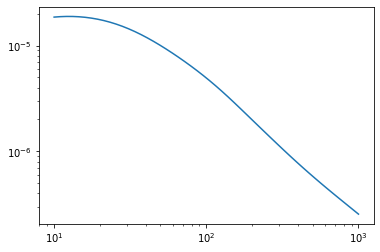

In [ ]:
loglog(ell, cls)

In [ ]:
# We can also jit it
jitted_angular_cl = jax.jit(angular_cl)

In [ ]:
jitted_angular_cl(cosmo, tracer, ell)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5792: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


DeviceArray([1.8582112e-05, 1.8764178e-05, 1.8851024e-05, 1.8837498e-05,
             1.8721008e-05, 1.8500676e-05, 1.8177325e-05, 1.7754815e-05,
             1.7237015e-05, 1.6630554e-05, 1.5947380e-05, 1.5198700e-05,
             1.4396513e-05, 1.3556604e-05, 1.2694548e-05, 1.1824462e-05,
             1.0960339e-05, 1.0115136e-05, 9.2975542e-06, 8.5157053e-06,
             7.7733575e-06, 7.0725505e-06, 6.4134692e-06, 5.7946331e-06,
             5.2147511e-06, 4.6724567e-06, 4.1674493e-06, 3.7001269e-06,
             3.2714006e-06, 2.8824413e-06, 2.5335419e-06, 2.2239365e-06,
             1.9514050e-06, 1.7126333e-06, 1.5037756e-06, 1.3211016e-06,
             1.1614500e-06, 1.0222160e-06, 9.0112985e-07, 7.9600858e-07,
             7.0471128e-07, 6.2526914e-07, 5.5597133e-07, 4.9536555e-07,
             4.4218501e-07, 3.9533080e-07, 3.5386662e-07, 3.1700597e-07,
             2.8409059e-07, 2.5457311e-07], dtype=float32)

### Solving ODEs


Sorry running out of time for this, but have a look  at how this is done [here](https://github.com/DifferentiableUniverseInitiative/jax_cosmo/blob/c2f8b59214df70d820bbad53f6a7b1ab2280638a/jax_cosmo/background.py#L471) 

## Conclusion

This is only the very tip of the iceberg!

Here are a few pointers to exciting things in JAX:
- [flax](https://github.com/google/flax) : Neural Network library
- [morphine](https://github.com/benjaminpope/morphine) : Super cool example of a project which has transitioned from numpy to jax, for the purpose of PSF modeling

